<a href="https://colab.research.google.com/github/2359181042/GNN_cs224w/blob/main/%E2%80%9CIreland_wells_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install pytorch_lightning

In [18]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import os
import json
import numpy as np
import pandas as pd
DATA_PATH = 'gdrive/My Drive/Ireland_data/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/gdrive


In [19]:

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib
from matplotlib.pyplot import figure


import pandas as pd
import numpy as np
from tqdm import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale = 1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize']=12,8
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# 1. analyze our data 
  #### The data include eight wells between Galway City and Lahinch City in Ireland island. We consider the hourly data from 2016.11.28 13:00-2021.7.1 0:00: groundwater level, thelog_elevation, and the rain, temp and vapour pressure.

In [20]:
df=pd.read_csv(os.path.join(DATA_PATH,'Data1.csv'))
loc=pd.read_csv(os.path.join(DATA_PATH,'sets.csv'))
df['Date'] = pd.to_datetime(df['Time'])
df['Day'] = df['Date'].dt.day
df['Month']=df['Date'].dt.month
df['Year']=df['Date'].dt.year
df['Hour']=df['Date'].dt.hour
df.index=df['Date']
df=df.drop(['Time'],axis=1)
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
cols = df.columns.tolist()
cols = cols[-4:]+cols[:-4]
df=df[cols]
df = df.rename(columns={'Lough Aleenaun': 'O1L', 'Unnamed: 2': 'O1E','Termon South':'O2L','Unnamed: 4':'O2E',  'Coole Lough':'O3L','Unnamed: 6':'O3E', 'Caherglassaun':'O4L','Unnamed: 8':'O4E', 'Black Rock':'O5L', 'Unnamed: 10':'O5E',
                        'Labane':'O6L','Unnamed: 12':'O6E','Caranavoodaun':'O7L', 'Unnamed: 14':'O7E'})


df.columns


Index(['Day', 'Month', 'Year', 'Hour', 'O1L', 'O1E', 'O2L', 'O2E', 'O3L',
       'O3E', 'O4L', 'O4E', 'O5L', 'O5E', 'O6L', 'O6E', 'O7L', 'O7E', 'rain',
       'temp', 'vp', 'Date'],
      dtype='object')

<Figure size 1280x400 with 0 Axes>

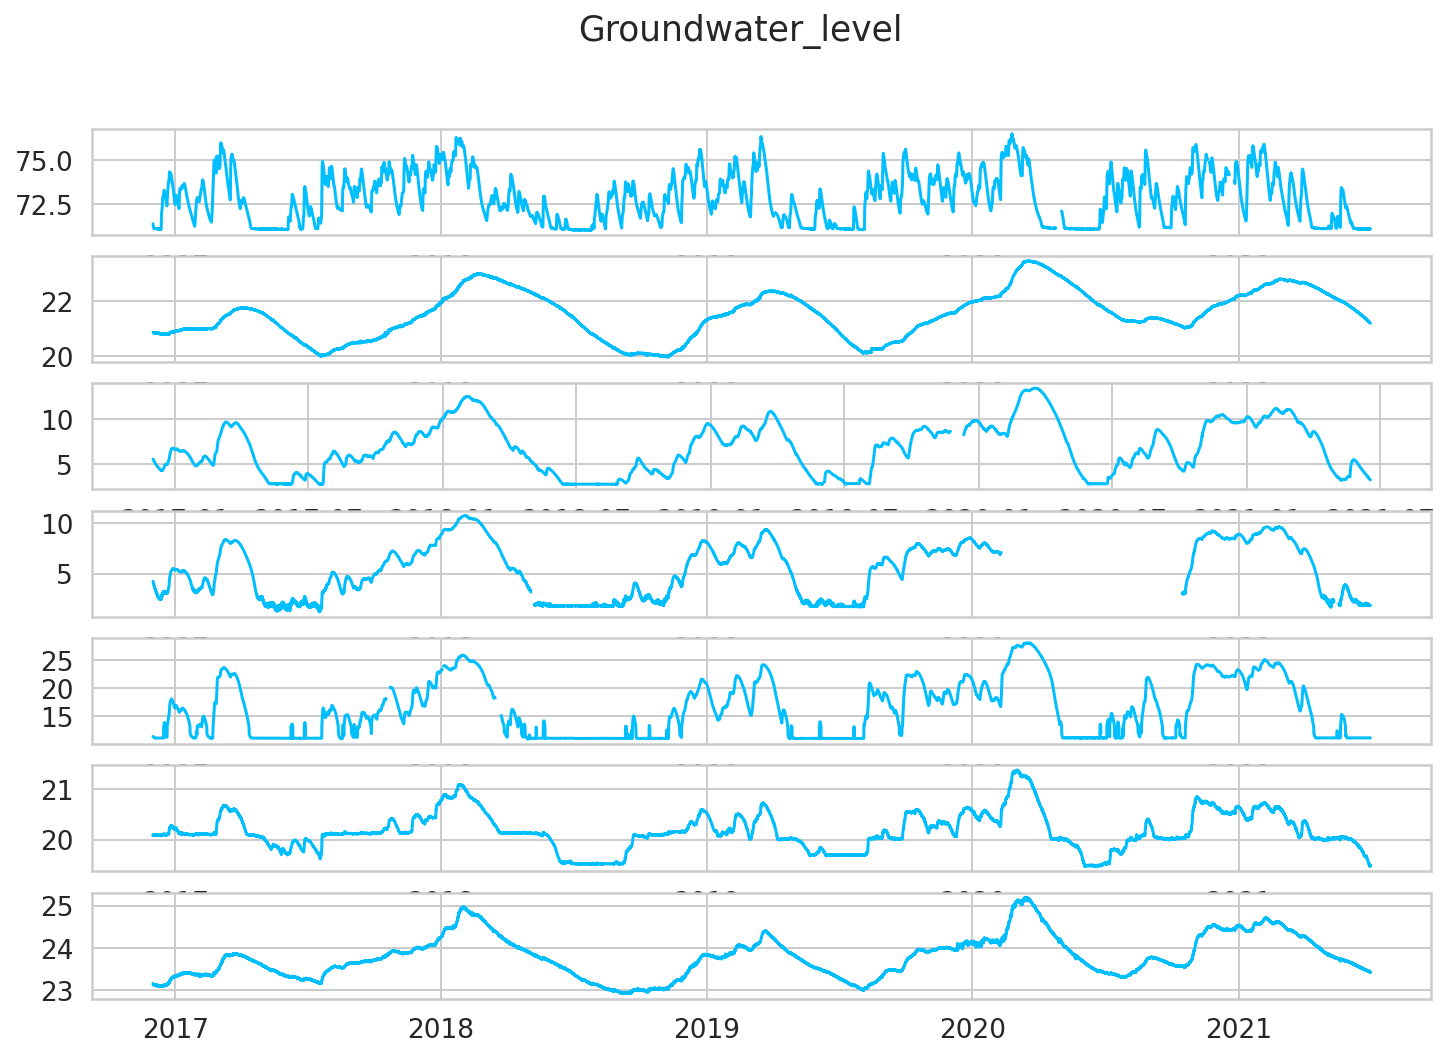

In [ ]:
figure(figsize=(16, 5), dpi=80)
fig, axs = plt.subplots(7)
fig.suptitle('Groundwater_level')
axs[0].plot(df.index, df['O1L'])
axs[1].plot(df.index, df['O2L'])
axs[2].plot(df.index, df['O3L'])
axs[3].plot(df.index, df['O4L'])
axs[4].plot(df.index, df['O5L'])
axs[5].plot(df.index, df['O6L'])
axs[6].plot(df.index, df['O7L'])


In [21]:
df2=df
df2['O1E']=df2['O1E'].fillna(method='ffill', axis=0)
df2['O3E']=df2['O3E'].fillna(method='ffill', axis=0)
df2['O4E']=df2['O4E'].fillna(method='ffill', axis=0)
df2['O5E']=df2['O5E'].fillna(method='ffill', axis=0)
df2['O1L']=df2['O1L'].fillna(method='ffill', axis=0)
df2['O3L']=df2['O3L'].fillna(method='ffill', axis=0)
df2['O5L']=df2['O5L'].fillna(method='ffill', axis=0)
df2['O4L']=df2['O4L'].fillna(method='ffill', axis=0)
df2=df2.drop(['O1E'],axis=1)
df2=df2.drop(['O1L'],axis=1)

In [22]:
df2['O2D']=df2['O2L']-df2['O2E']
df2['O3D']=df2['O3L']-df2['O3E']
df2['O4D']=df2['O4L']-df2['O4E']
df2['O5D']=df2['O5L']-df2['O5E']
df2['O6D']=df2['O6L']-df2['O6E']
df2['O7D']=df2['O7L']-df2['O7E']

<Figure size 1280x400 with 0 Axes>

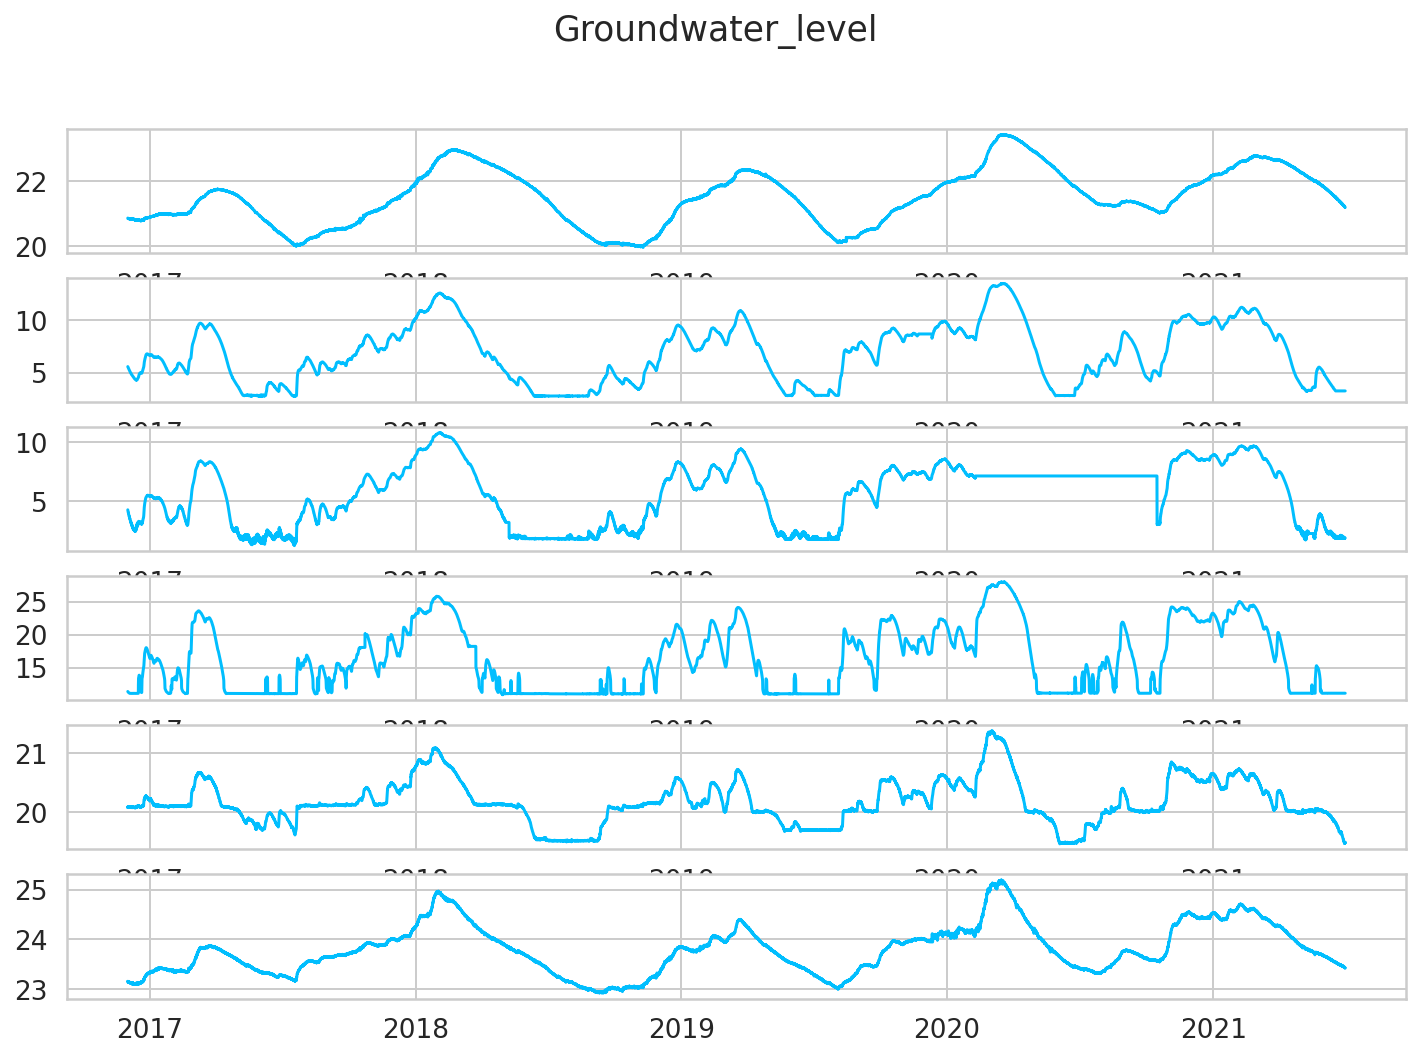

In [ ]:
figure(figsize=(16, 5), dpi=80)
fig, axs = plt.subplots(6)
fig.suptitle('Groundwater_level')

axs[0].plot(df2.index, df2['O2L'])
axs[1].plot(df2.index, df2['O3L'])
axs[2].plot(df2.index, df2['O4L'])
axs[3].plot(df2.index, df2['O5L'])
axs[4].plot(df2.index, df2['O6L'])
axs[5].plot(df2.index, df2['O7L'])

## Now the data are cleaned for 1 2 3 5 6 7, while 4 is lacking.

## The training data can be from 2017-2020,test data can be later

In [23]:
rows=[]
for _, row in tqdm(df2.iterrows(),total = df2.shape[0]):
  row_data=dict(
      O2L=row.O2L,
      O3L=row.O3L,
      O4L=row.O4L,
      O5L=row.O5L,
      O6L=row.O6L,
      O7L=row.O7L,
      O2D=row.O2D,
      O3D=row.O3D,
      O4D=row.O4D,
      O5D=row.O5D,
      O6D=row.O6D,
      O7D=row.O7D,
      O2E=row.O2E,
      O3E=row.O3E,
      O4E=row.O4E,
      O5E=row.O5E,
      O6E=row.O6E,
      O7E=row.O7E,
      rain=row.rain,
      temp=row.temp,
      vp=row.vp,
      day=row.Day,
      month=row.Month,
      year=row.Year,
      hour=row.Hour
  )
  rows.append(row_data)
features_df=pd.DataFrame(rows)

100%|██████████| 40140/40140 [00:13<00:00, 2980.07it/s]


In [24]:
train_size= int(len(features_df)*0.6)
val_size=int(len(features_df)*0.85)
test_size=int(len(features_df)*0.95)
print(train_size,val_size,test_size)

24084 34119 38133


In [25]:
train_df=features_df[:train_size]
val_df=features_df[val_size:test_size]
test_df=features_df[test_size:]
print(len(train_df),len(val_df),len(test_df))

24084 4014 2007


In [26]:
def create_sequences(input_data:pd.DataFrame,number,TIME_WINDOW,PRED_TIME):
  sequences=[]
  data_size=len(input_data)
  #print(number)
  for i in tqdm(range(data_size-TIME_WINDOW-PRED_TIME)):
    sequence = input_data[i:i+TIME_WINDOW]
    weather_for = input_data.iloc[i+TIME_WINDOW:i+TIME_WINDOW+PRED_TIME,18:21]
    label = input_data.iloc[i+TIME_WINDOW:i+TIME_WINDOW+PRED_TIME,0:number]
    #print(f'label{label}')
    sequences.append((sequence,weather_for,label))
  return sequences


In [27]:
number=6
TIME_WINDOW=720
PRED_TIME=72
train_sequences=create_sequences(train_df,number,TIME_WINDOW,PRED_TIME)
val_sequences=create_sequences(val_df,number,TIME_WINDOW,PRED_TIME)
test_sequences=create_sequences(test_df,number,TIME_WINDOW,PRED_TIME)

100%|██████████| 1215/1215 [00:00<00:00, 1726.32it/s]


In [13]:
print(train_sequences[0][0].shape)
print(train_sequences[0][1].shape)
print(train_sequences[0][2].shape)

(720, 25)
(72, 3)
(72, 6)


In [28]:

Well_location= pd.read_csv(os.path.join(DATA_PATH,'sets.csv'))

NE=[]
North=[]
East=[]
for i in range(2,8):
    N=Well_location.iloc[0][i]
    North.append(N)
    E=Well_location.iloc[1][i]
    East.append(E)
    NE.append((N,E))
print(len(NE))
print(NE)
print(North)
print(East)

6
[(53.022037, 8.873746), (53.086776, 8.849339), (53.104572999999995, 8.870828), (53.121168999999995, 8.751982), (53.139996, 8.804413), (53.184284999999996, 8.810231)]
[53.022037, 53.086776, 53.104572999999995, 53.121168999999995, 53.139996, 53.184284999999996]
[8.873746, 8.849339, 8.870828, 8.751982, 8.804413, 8.810231]


In [29]:
from math import sin, cos, sqrt, atan2, radians
R = 6378.1370
specific_distance=6
def get_conn_attr(N,E):
    Distance = []
    con_i=[]
    con_j=[]
    for i in range(len(N)):
        for j in range(len(N)):
          #print('this is Ni',N[i],E[i])
          lat1 = radians(N[i])
          lon1 = radians(E[i])
          lat2 = radians(N[j])
          lon2 = radians(E[j])
          dlon = lon2 - lon1
          dlat = lat2 - lat1
          a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
          c = 2 * atan2(sqrt(a), sqrt(1 - a))
          distance = R * c
          if (distance < specific_distance) & (distance > 0):
              con_i.append(i)
              con_j.append(j)
              Distance.append(distance)

    conn=torch.tensor([con_i,con_j])
    edge_attr = torch.tensor([Distance])
    edge_attr = edge_attr.transpose(0, 1) 
    edge_attr = edge_attr.unsqueeze(0).repeat(6,1,1)
    return conn, edge_attr

In [30]:
Conn,Edge_attr=get_conn_attr(North,East)
print(Conn)
print(Edge_attr.shape)

tensor([[1, 2, 2, 3, 4, 4, 4, 5],
        [2, 1, 4, 4, 2, 3, 5, 4]])
torch.Size([6, 8, 1])


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import os
import json
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, atan2, radians





In [32]:
class WellDataset(Dataset):
  def __init__(self,sequences,conn,edge_attr):
    self.sequences= sequences
    self.conn=conn
    self.edge_attr=edge_attr
  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, index):
    sequence,weather_for,label=self.sequences[index]
    return dict(
        sequence=torch.Tensor(sequence.to_numpy()),
        weather_for=torch.Tensor(weather_for.to_numpy()),
        conn=self.conn,
        edge_attr=self.edge_attr,
        label= torch.Tensor(label.to_numpy()).float()       
    )

In [33]:
class WellDataModule(pl.LightningDataModule):
  def __init__(
      self, train_sequences, val_sequences,test_sequences,North,East,batch_size
  ):
    super().__init__()
    self.conn=Conn
    self.edge_attr=Edge_attr
    self.train_sequences=train_sequences
    self.val_sequences=val_sequences
    self.test_sequences=test_sequences
    self.batch_size=batch_size
  def setup(self):
    self.train_dataset= WellDataset(self.train_sequences,self.conn,self.edge_attr)
    self.val_dataset= WellDataset(self.val_sequences,self.conn,self.edge_attr)
    self.test_dataset=WellDataset(self.test_sequences,self.conn,self.edge_attr)
  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
    )
  def val_dataloader(self):
    return DataLoader(
        self.val_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=2
    )

# Model

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean, scatter_add
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
device

device(type='cuda')

In [43]:
class RNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNEncoder, self).__init__()
        self.input_size=input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)

    def forward(self, x, h0, c0):
        # Set initial hidden and cell states
        # Forward propagate LSTM
        out, (h_n, c_n) = self.lstm(x, (h0, c0))  
        # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        #print('encoder shape',h_n.shape,c_n.shape)
        return h_n, c_n
class RNNDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNDecoder, self).__init__()
        self.input_size=input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.lin = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        #print('this is hidden size in RNN decoder',hidden_size)

    def forward(self, x, h_0, c_0):
        # Forward propagate LSTM
        out, (h_n, c_n) = self.lstm(x, (h_0, c_0)) # out [768, 1, 64]
        out = self.lin(out) #  out [768, 1, 1]
        out = self.relu(out) # [768, 1, 1]
      
        return out, h_n, c_n

In [45]:

class WellModel(nn.Module):
  def __init__(self, L_em,D_em,E_em,T_em, W_em,well_num, rnn_h, rnn_l, gnn_h):
    super(WellModel,self).__init__()
    self.L_em=L_em
    self.D_em=D_em
    self.E_em=E_em
    self.T_em=T_em
    self.W_em=W_em
    self.well_num=well_num
    self.rnn_h=rnn_h
    self.gnn_h=gnn_h
    self.rnn_l=rnn_l

    self.L_embed = nn.Sequential(
      nn.Linear(1,self.L_em),
      nn.ReLU()
    )
    self.E_embed = nn.Sequential(
      nn.Linear(1,self.E_em),
      nn.ReLU()
    )
    self.D_embed = nn.Sequential(
      nn.Linear(1,self.D_em),
      nn.ReLU()
    )
    self.T_embed = nn.Sequential(
      nn.Linear(4,self.T_em),
      nn.ReLU()
    )
    self.W_embed = nn.Sequential(
      nn.Linear(3,self.W_em),
      nn.ReLU()
    )    
    self.well_gnn=WellGNN(64,1,self.gnn_h) # node feature is the sum of em, edge feature is 1
    self.encoder = RNNEncoder(input_size=self.gnn_h,
                  hidden_size=self.rnn_h,
                  num_layers=self.rnn_l)
    self.decoder_embed=nn.Sequential(
      nn.Linear(1,self.L_em),            
      nn.ReLU()            
    )
    self.decoder=RNNDecoder(input_size=self.L_em+3,
                hidden_size=self.rnn_h,
                num_layers=self.rnn_l)
  def batchInput(self,x,edge_w,edge_conn):
    x=x.reshape(-1,x.shape[-1])
    edge_w=edge_w.reshape(-1,edge_w.shape[-1])    
    for i in range(edge_conn.size(0)):
      edge_conn[i,:]=torch.add(edge_conn[i,:],i*self.well_num) 
    edge_conn=edge_conn.transpose(0,1)                     
    edge_conn=edge_conn.reshape(2,-1)
    return x,edge_w,edge_conn
  def forward(self,data,device):
    device=device
    label=data['label'].transpose(1,2).to(device) #[128,72,6] ->[128, 6, 72]
    features= data['sequence'].to(device)  #[128, 720, 25]
    weather_for=data['weather_for'].to(device) #[128, 72, 3]
    conn=data['conn'].to(device)         #[128, 2, 8]
    edge_attr=data['edge_attr'].to(device)    #[128, 6, 8, 1]

    #print(features.is_cuda)
    L=features[:,:,:6]  # (128, 720, 6)
    D=features[:,:,6:12]
    E=features[:,:,12:18]
    W=features[:,:,18:21]
    T=features[:,:,[23,22,21,24]]
    #print('L',L.is_cuda)
    Lev=L.unsqueeze(dim=-1).to(torch.float32)
    Lev=self.L_embed(Lev)        #[128, 720, 6, 16]
    
    Dif=D.unsqueeze(dim=-1).to(torch.float32)
    Dif=self.D_embed(Dif)         #[128, 720, 6, 16]

    Ele=E.unsqueeze(dim=-1).to(torch.float32)
    Ele=self.E_embed(Ele)         #[128, 720, 6, 8]

    Wea=W.unsqueeze(dim=-2).to(torch.float32)
    Wea=self.W_embed(Wea)
    Wea=Wea.repeat(1,1,6,1)       #[128, 720, 6, 16]

    Tim=T.unsqueeze(dim=-2).to(torch.float32)
    Tim=self.T_embed(Tim)
    Tim=Tim.repeat(1,1,6,1)        #[128, 720, 6, 8]

    x=torch.cat([Lev,Dif,Ele,Wea,Tim],dim=-1) #16+16+8+16+8=64 [128, 720, 6, 64]
    conn=conn.repeat(self.well_num,1,1).to(torch.float32) # [128,2,8] -> [768, 2, 8]
    edge_attr = edge_attr.reshape(-1, edge_attr.shape[-2], edge_attr.shape[-1]).to(torch.float32) # [128, 6, 8, 1] -> [768, 8, 1]
    x, edge_attr, conn = self.batchInput(x, edge_attr, conn) # x:[552960, 64] edge_attr:[6144, 1] conn: [2, 6144]


    x = self.well_gnn(x, conn,edge_attr,device) # x [552960, 32]
    x = x.reshape(-1, TIME_WINDOW, self.well_num, x.shape[-1]).transpose(1, 2) # x [128, 6, 720, 32]
    x = x.reshape(-1, TIME_WINDOW, x.shape[-1]) # x [768, 720, 32]

    h0 = torch.randn(self.rnn_l, x.size(0), self.rnn_h).to(device)
    c0 = torch.randn(self.rnn_l, x.size(0), self.rnn_h).to(device)
    h_x, c_x = self.encoder(x, h0, c0)

    outputs = torch.zeros((x.size(0), weather_for.size(1), 1)).to(device) # [768, 72, 1]

    
    QL=label[:,:,0]               # [128, 6]
    QL=QL.reshape(-1,1)             # [768, 1]
    weather_for=weather_for.repeat(self.well_num,1,1).to(torch.float32) #[768, 72, 3]


    for i in range(weather_for.size(1)):
      QL_em=self.decoder_embed(QL)
      inputs=torch.cat((QL_em,weather_for[:,i]),dim=-1) #inputs [768, 19]
      inputs=inputs.unsqueeze(dim=1)          #inputs  [768, 1, 19]
      output,h_x,c_x=self.decoder(inputs,h_x,c_x)   #output [768, 1, 1]
      output = output.squeeze(2)         #output [768, 1]
      outputs[:,i,:]=output
      QL=output                    #QL [768, 1]
    outputs=outputs.reshape(-1,self.well_num,weather_for.size(1)) #outputs [128, 6, 72]

    return outputs

class WellGNN(torch.nn.Module):
  def __init__(self,node_h=64,edge_h=1,gnn_h=32):
    super(WellGNN,self).__init__()
    self.node_mlp_1 =nn.Sequential(
      nn.Linear(2 * node_h + edge_h, gnn_h),
      nn.ReLU(inplace=True)
    )

    self.node_mlp_2 =nn.Sequential(
      nn.Linear(node_h + gnn_h, gnn_h),
      nn.ReLU(inplace=True)
    )
  def forward(self, x, edge_index, edge_attr,device):
    # x: [N, F_x], where N is the number of nodes.
    # edge_index: [2, E] with max entry N - 1.
    # edge_attr: [E, F_e]
    #u = u.reshape(-1, u.shape[-1])
    #u = u.repeat(sta_num, 1)
    device=device
    x=x.to(device)
    edge_index=edge_index.to(device)
    edge_attr=edge_attr.to(device)
    #print('edge_index',edge_index.is_cuda)
    row, col = edge_index
    row = row.type(torch.LongTensor).to(device)
    col = col.type(torch.LongTensor).to(device) # need to be torch.longTensor type

    #torch.LongTensor(rows)    
    #print('col',col.is_cuda)
    out = torch.cat([x[row], x[col], edge_attr], dim=1)
    #print('out',out.is_cuda)
    out = self.node_mlp_1(out)
    #print('out',out.is_cuda)
    out = scatter_mean(out, col, dim=0, dim_size=x.size(0)).to(device)
    #print('out',out.is_cuda)
    out = torch.cat([x, out], dim=1)
    #print('out',out.is_cuda) #delete u
    return self.node_mlp_2(out)

In [37]:
TIME_WINDOW=720
PRED_TIME=72
L_em=16
D_em=16
E_em=8
T_em=8
W_em=16
well_num=6
rnn_h=64
gnn_h=32
rnn_l=1
lr=0.001
Epoch=20
BATCH_SIZE=128

In [46]:
model=WellModel(L_em,D_em, E_em,T_em, W_em,well_num, rnn_h, rnn_l, gnn_h).to(device)
model_num = sum(p.numel() for p in model.parameters()
                      if p.requires_grad)
print('model:', 'Trainable,', model_num)
criterion = nn.MSELoss()
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.001)
print(device)
val_loss_min = 0.01
data_module=WellDataModule(train_sequences,val_sequences,test_sequences,Conn,Edge_attr,batch_size=BATCH_SIZE)
data_module.setup()

model: Trainable, 54393
cpu


In [38]:
model = WellModel(L_em,D_em, E_em,T_em, W_em,well_num, rnn_h, rnn_l, gnn_h).to(device)
model.load_state_dict(torch.load(F"/content/gdrive/My Drive/new_temp_model19:0.ckpt"))
model_num = sum(p.numel() for p in model.parameters()
                      if p.requires_grad)
print('model:', 'Trainable,', model_num)
criterion = nn.MSELoss()
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.001)

val_loss_min = 0.01
data_module=WellDataModule(train_sequences,val_sequences,test_sequences,Conn,Edge_attr,batch_size=BATCH_SIZE)
data_module.setup()

RuntimeError: ignored

In [27]:
#@title 默认标题文本
a=[]
b=[]
c=[]
d=[]
for epoch in range(Epoch):
  for i,data in enumerate(data_module.train_dataloader()):
    data=data

    label=data['label'].transpose(1,2).to(device) #128*24*6 -> 128*6*24
    #sequences=[features,weather_for,conn,edge_attr]
    #print(sequences.is_cuda())
    outputs = model(data,device)
    #print('label',label.shape)
    a.append((outputs[1:],label[1:]))
    
    

    #a.append(loss.item())
    optimizer.zero_grad()
    loss = criterion(outputs, label)
    loss.backward() 
    torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1)
    optimizer.step()
    if i % 10 ==0 and epoch % 1 ==0:
      print("Epoch [{}/{}], step [{}/{}],loss {:.4f} ".format(
          epoch,10,i,int(len(train_sequences)/BATCH_SIZE),loss.item()
      ))
  val_loss=0
  with torch.no_grad():
    for j,data in enumerate(data_module.val_dataloader()):
      
      data = data
      label=data['label'].transpose(1,2).to(device)
      outputs = model(data,device)
      c.append((outputs,label))  


      val_loss= criterion(outputs, label)
      d.append(val_loss.item())
      if epoch % 1 ==0 and j % 1000 ==0:
        print("Epoch [{}/{}], step [{}/{}],loss {:.4f} ".format(
          epoch,10,j,int(len(test_sequences)/BATCH_SIZE),val_loss.item()
      ))
      if epoch % 1 ==0 and j==0:
        name = F'new_temp_model{epoch}:{j}.ckpt'
        path = F"/content/gdrive/My Drive/{name}" 
        torch.save(model.state_dict(), path)
        

    if val_loss < val_loss_min and epoch > (Epoch * 0.7):
      print('Model can be saved')
      model_save_name = F'FINAL_Ireland_well{epoch}.ckpt'
      path = F"/content/gdrive/My Drive/{model_save_name}" 
      torch.save(model.state_dict(), path)  
      #torch.save(model.state_dict(),'./checkpoints/global.ckpt')
    
      val_loss_min = val_loss
print('Finished Training')


Epoch [0/10], step [0/181],loss 6.0428 
Epoch [0/10], step [10/181],loss 5.6380 
Epoch [0/10], step [20/181],loss 1.3158 
Epoch [0/10], step [30/181],loss 2.4931 
Epoch [0/10], step [40/181],loss 3.2249 
Epoch [0/10], step [50/181],loss 2.9646 
Epoch [0/10], step [60/181],loss 1.7770 
Epoch [0/10], step [70/181],loss 2.2777 
Epoch [0/10], step [80/181],loss 4.1140 
Epoch [0/10], step [90/181],loss 2.6588 
Epoch [0/10], step [100/181],loss 2.7306 
Epoch [0/10], step [110/181],loss 1.2761 
Epoch [0/10], step [120/181],loss 1.2377 
Epoch [0/10], step [130/181],loss 1.6885 
Epoch [0/10], step [140/181],loss 2.0481 
Epoch [0/10], step [150/181],loss 2.0367 
Epoch [0/10], step [160/181],loss 3.4633 
Epoch [0/10], step [170/181],loss 5.9488 
Epoch [0/10], step [180/181],loss 4.3315 
Epoch [0/10], step [0/9],loss 3.1757 
Epoch [0/10], step [1000/9],loss 2.7515 
Epoch [0/10], step [2000/9],loss 2.4441 
Epoch [0/10], step [3000/9],loss 4.8239 
Epoch [1/10], step [0/181],loss 6.0506 
Epoch [1/10]

In [ ]:

model_save_name = F'FINAL_Ireland_well9.ckpt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)  

In [28]:
print(len(a))
print(len(b))
print(len(c))
print(len(d))

3640
0
64440
64440


In [29]:
train_outputs=[]
train_y=[]
for i in range(len(a)):
  train_outputs.append(a[i][0])
  train_y.append(a[i][1])
print(len(train_outputs))

3640


In [30]:
val_outputs=[]
val_y=[]
for i in range(len(c)):
  val_outputs.append(c[i][0])
  val_y.append(c[i][1])
print(len(val_outputs))

64440


In [31]:
torch.save(train_outputs, F"/content/gdrive/My Drive/train_outputs.pt")

In [32]:
torch.save(train_y, F"/content/gdrive/My Drive/train_y.pt")

In [33]:
torch.save(val_outputs, F"/content/gdrive/My Drive/val_outputs.pt")

In [34]:
torch.save(val_y, F"/content/gdrive/My Drive/val_y.pt")

In [ ]:
torch.save(b, F"/content/gdrive/My Drive/train_loss.pt")

In [45]:
torch.save(d, F"/content/gdrive/My Drive/val_loss.pt")

In [5]:
import torch
new_outputs=torch.load(F"/content/gdrive/My Drive/val_outputs.pt",map_location=torch.device('cpu'))
new_y=torch.load(F"/content/gdrive/My Drive/val_y.pt",map_location=torch.device('cpu'))
print(new_outputs[62000][0][0][1])
print(new_y[62000][0][0][1]) 

tensor(21.9798)
tensor(22.0640)


[tensor(9.5957), tensor(9.3828), tensor(8.7318), tensor(8.2611), tensor(8.0332), tensor(8.0086), tensor(8.1801), tensor(8.3377), tensor(8.4319), tensor(8.4862), tensor(8.5082), tensor(8.5272), tensor(8.5355), tensor(8.5439), tensor(8.5551), tensor(8.5691), tensor(8.5880), tensor(8.6909), tensor(9.0557), tensor(9.5543), tensor(9.8609), tensor(9.9839), tensor(10.0452), tensor(10.0646), tensor(10.0733), tensor(10.0805), tensor(10.0843), tensor(10.0900), tensor(10.0944), tensor(10.0932), tensor(10.0877), tensor(10.0762), tensor(10.0458), tensor(10.0261), tensor(10.0234), tensor(10.0229), tensor(10.0276), tensor(10.0147), tensor(10.0135), tensor(10.0112), tensor(10.0109), tensor(10.0150), tensor(10.0510), tensor(10.2079), tensor(10.4271), tensor(10.5781), tensor(10.6397), tensor(10.6701), tensor(10.6995), tensor(10.7044), tensor(10.6997), tensor(10.7043), tensor(10.6983), tensor(10.6915), tensor(10.6763), tensor(10.6767), tensor(10.6625), tensor(10.6615), tensor(10.6707), tensor(10.6698), t

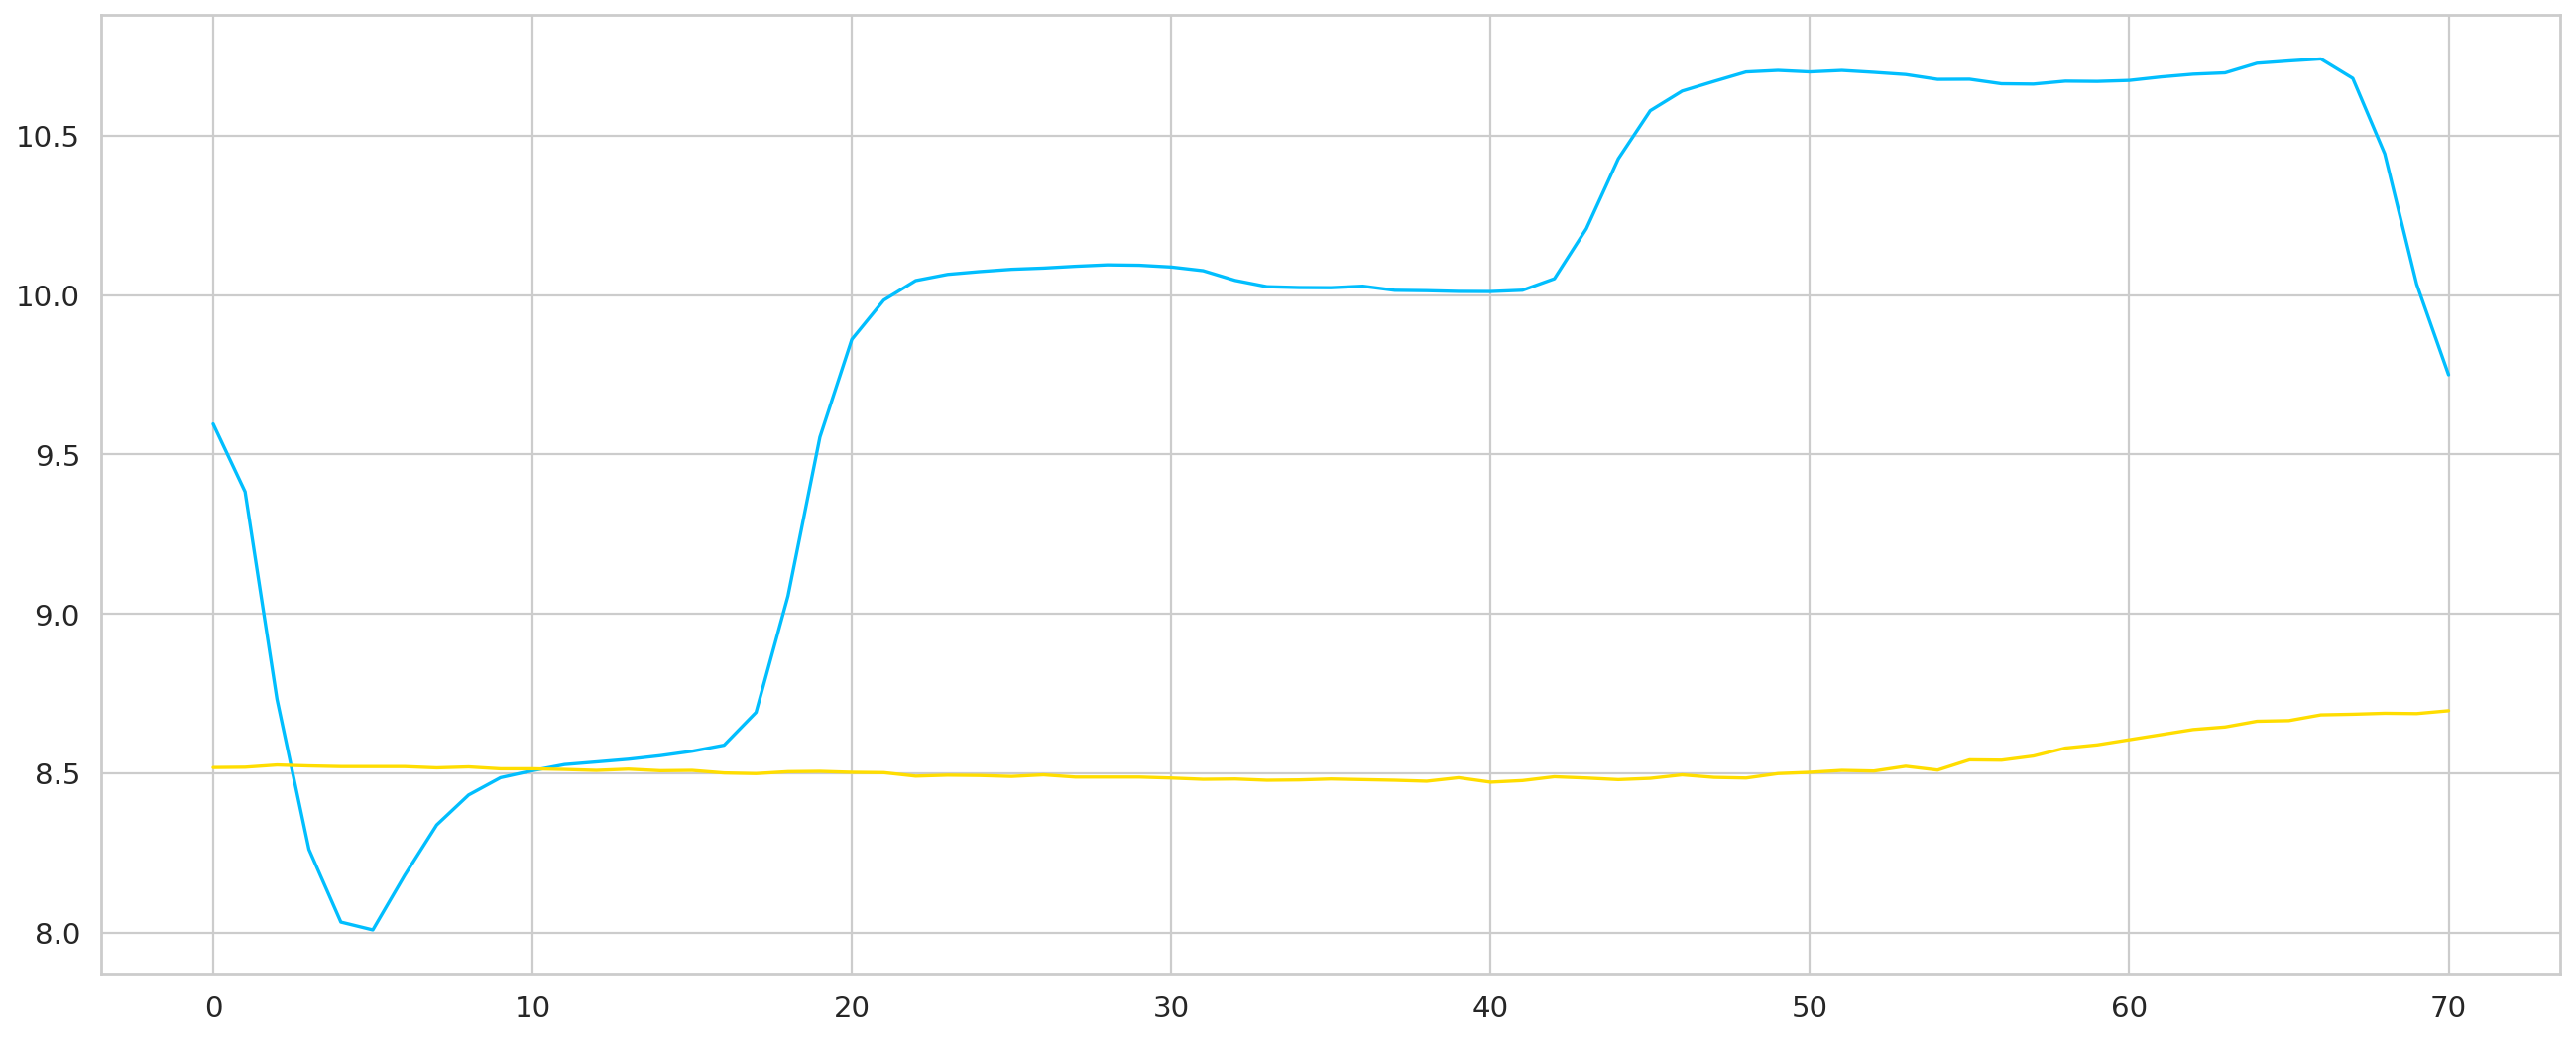

In [12]:
a=[]
b=[]
x=range(71)
for i in range(0,71):
  a.append(new_outputs[62000][0][2][i])
  b.append(new_y[62000][0][2][i])
figure(figsize=(20, 8), dpi=80)
print(a,'\n',b)
plt.plot(x,a,b)

In [16]:
print(len(val_sequences)*20-3222)

NameError: ignored

In [13]:
o0=[]
p0=[]
o1=[]
p1=[]
o2=[]
p2=[]
o3=[]
p3=[]
o4=[]
p4=[]
o5=[]
p5=[]
for i in range(61218,64440,72):
  for j in range(2,72):
    o0.append(new_outputs[i][0][0][j].item())
    p0.append(new_y[i][0][0][j].item())
    o1.append(new_outputs[i][0][1][j].item())
    p1.append(new_y[i][0][1][j].item())
    o2.append(new_outputs[i][0][2][j].item())
    p2.append(new_y[i][0][2][j].item())
    o3.append(new_outputs[i][0][3][j].item())
    p3.append(new_y[i][0][3][j].item())

    o4.append(new_outputs[i][0][4][j].item())
    p4.append(new_y[i][0][4][j].item())
    o5.append(new_outputs[i][0][5][j].item())
    p5.append(new_y[i][0][5][j].item())

  

In [14]:
o0=torch.tensor(o0).to('cpu')
p0=torch.tensor(p0).to('cpu')
o1=torch.tensor(o1).to('cpu')
p1=torch.tensor(p1).to('cpu')
o2=torch.tensor(o2).to('cpu')
p2=torch.tensor(p2).to('cpu')
o3=torch.tensor(o3).to('cpu')
p3=torch.tensor(p3).to('cpu')
o4=torch.tensor(o4).to('cpu')
p4=torch.tensor(p4).to('cpu')
o5=torch.tensor(o5).to('cpu')
p5=torch.tensor(p5).to('cpu')

In [1]:
plt.plot(d)

NameError: ignored

<Figure size 1600x640 with 0 Axes>

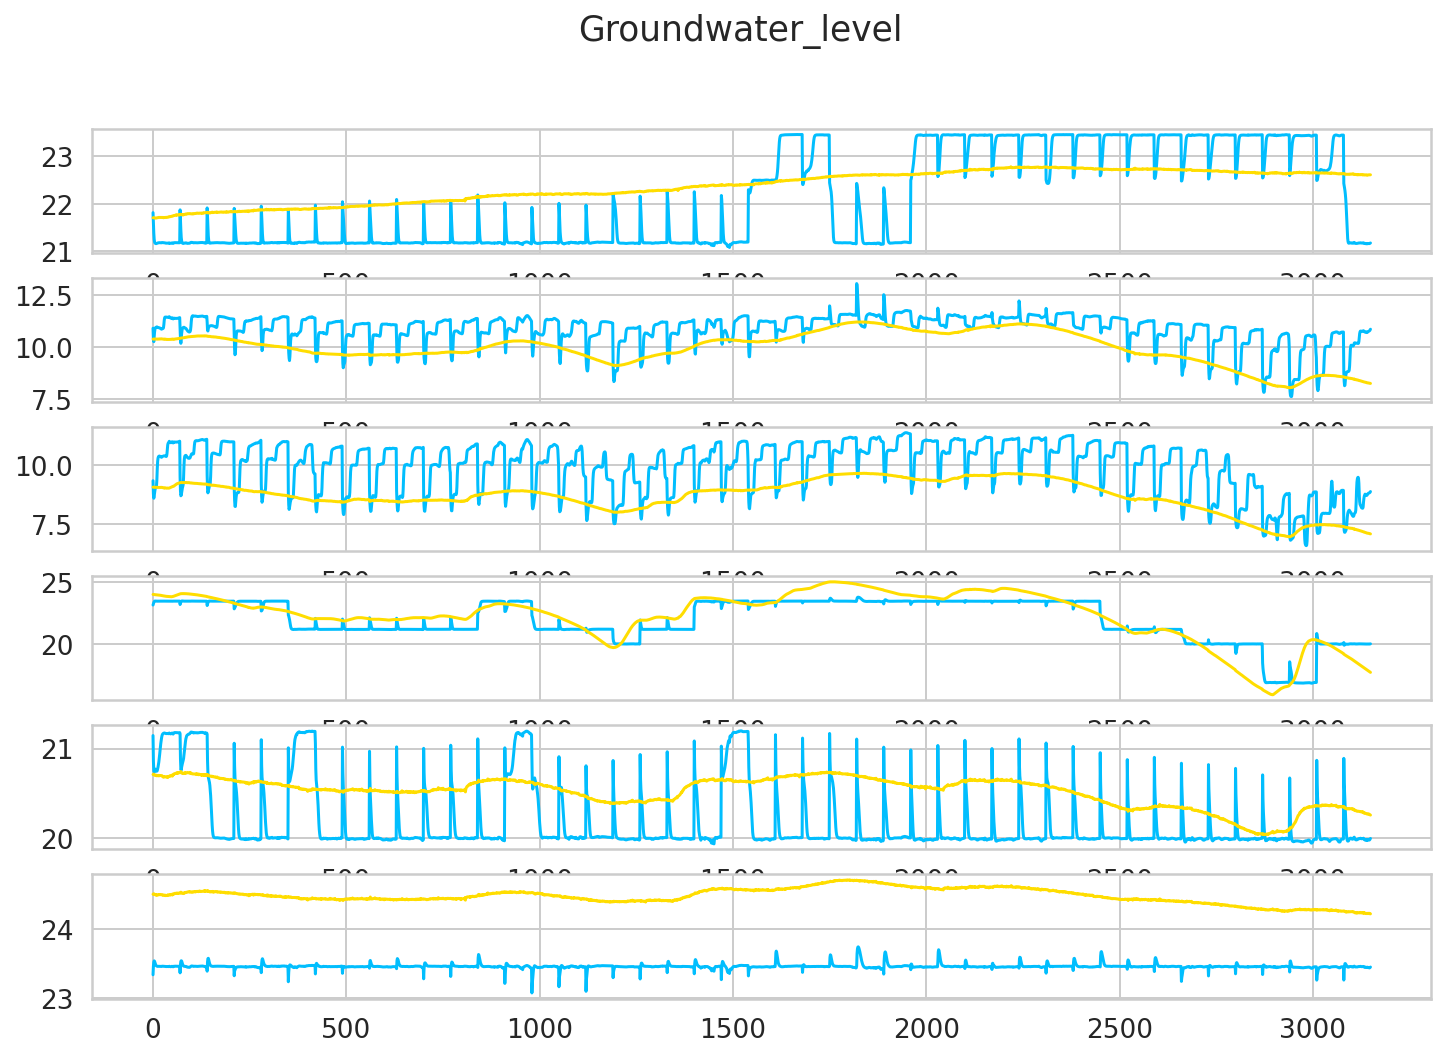

In [15]:
x=range(0,3150)
figure(figsize=(20, 8), dpi=80)
fig, axs = plt.subplots(6)
fig.suptitle('Groundwater_level')

axs[0].plot(x, o0,p0)
axs[1].plot(x, o1,p1)
axs[2].plot(x, o2,p2)
axs[3].plot(x, o3,p3)
axs[4].plot(x, o4,p4)
axs[5].plot(x, o5,p5)

torch.Size([1, 6, 24])
tensor(0.0180)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.1554, 0.1529, 0.1504, 0.1529, 0.1504, 0.1454, 0.1504, 0.1391, 0.1404,
        0.1353, 0.1303, 0.1341, 0.1266, 0.1316, 0.1253, 0.1253, 0.1266, 0.1266,
        0.1216, 0.1241, 0.1203, 0.1140, 0.1153, 0.1153])


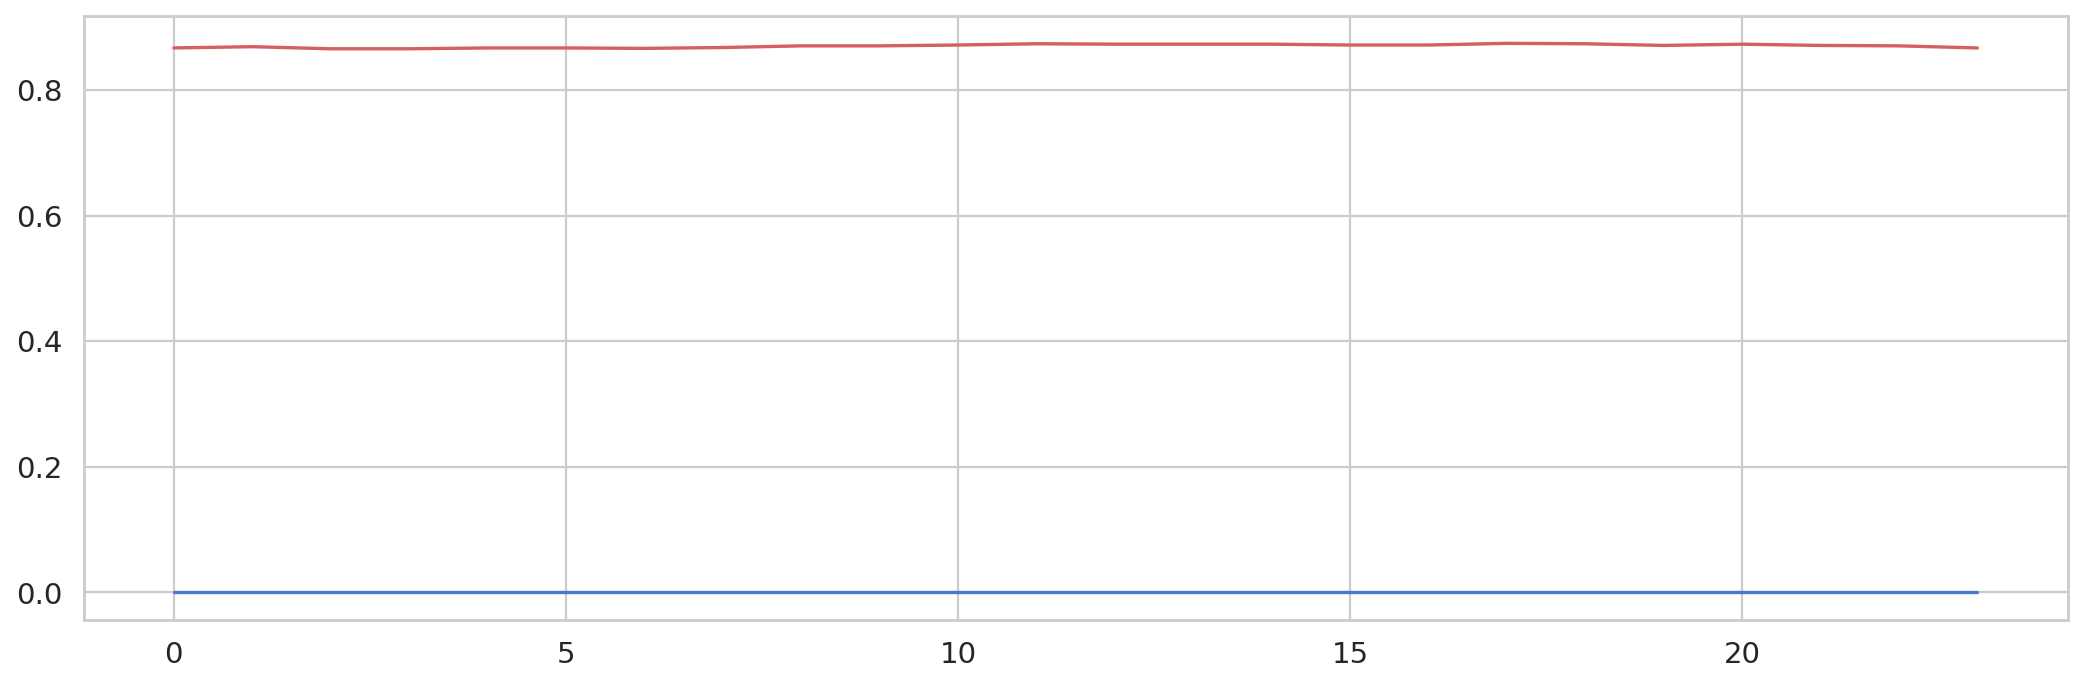

In [ ]:
print(val_outputs[2999].shape)
print(criterion(val_outputs[2999][0][4],val_y[2999][0][4],))
print(val_outputs[2000][0][4])
print(val_y[2999][0][4])
x=range(24)
figure(figsize=(16, 5), dpi=80)

fig.suptitle('Groundwater_level')

plt.plot(x,val_outputs[2840][0][0],'b',val_y[2840][0][0],'r')



In [ ]:
with open("test.txt", "r") as fp:
     b = json.load(fp)

In [ ]:
for item in a:
  print(item[0].shape)
  print(item[1].shape)
  print(criterion(item[0], item[1]))
  print(criterion(item[0][1,1,1],item[1][1,1,1]))
  print(criterion(item[0][127,6,23],item[1][127,6,23]))
  break

torch.Size([128, 7, 24])
torch.Size([128, 7, 24])
tensor(968.9291, grad_fn=<MseLossBackward>)
tensor(432.8065, grad_fn=<MseLossBackward>)
tensor(534.4420, grad_fn=<MseLossBackward>)


In [ ]:
for item in c:
  print(item[0].shape)
  print(item[1].shape)
  print(criterion(item[0], item[1]))
  print(criterion(item[0][0,1,23],item[1][0,1,23]))

  break

torch.Size([1, 7, 24])
torch.Size([1, 7, 24])
tensor(587.6411)
tensor(48.1752)


In [ ]:
for epoch in range(3):
  model_save_name = F'Ireland_well{epoch}.ckpt'
  path = F"/content/gdrive/My Drive/{model_save_name}" 
  torch.save(model.state_dict(), path) 
  for j in range(3):
    if epoch % 1 ==0 and j==0:
      name = F'temp_model{epoch}:{j}.ckpt'
      path = F"/content/gdrive/My Drive/{name}" 
      torch.save(model.state_dict(), path)